# The Random Forest Algorithm

The random forest algorithm is a machine learning method that joins multiple decision tree instances to perform classification or regression. Such combinations are known as ensemble learning models. The term 'random forest' is derived from the inverted forest-like appearance of a multiple decision trees joined at the head.

Here we will demonstrate an implementation of classification (predicting labels of objects based on past experience). This is a type of supervised learning, where we train the algorithm on example data, and then run it on a test dataset.

First we need to understand the basics - the decision tree.

This tutorial is derived from the work of Will Koehrsen. For more details, see [here](https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76), and also [here](https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb)

## Learning outcomes:
- Understand how decision trees work to classify data.
- Understand the basics of random forests
- Use scikit learn's decision tree and random forest classifiers
- Assess quality of classification algorithms by visualising the True Positive and False Positive Rates using the "confusion matrix".

## 1. Decision Trees

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

We can think of a DT as a series of sequential yes/no questions like a flowchart. The final result of the tree is a class label (classification) or value (regression).

<img src="Images/dog_cat_decision_tree.png">

A decision tree model is trained and built by determing the questions that lead to the 'best result'. In practice the best result is determined by the greatest reduction in the *Gini Impurity*. This is simply a measurement of the likelihood of an incorrect classification of a new instance of a random variable - 0 is perfect classification.

## 1.1 A toy example

We start with a very simple example - binary classification in 2D. This is where we can plot two classes of object on a 2D scatter plot, where the x- and y-axis are the features that describe the data. Traditionally in the ML world denote the features as an array *X* and the labels as a vector *y*.

#### Create and plot simple data

It is easier to understand the data if we visualise it in 2D:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot formatting
plt.rcParams['font.size'] = 18
plt.figure(figsize = (8, 8))

# Plot each point as the label
for x1, x2, label in zip(X[:, 0], X[:, 1], y):
    plt.text(x1, x2, str(label), fontsize = 40, color = 'g',
             ha='center', va='center')
    
# Plot formatting
plt.grid(None);
plt.xlim((0, 3.5));
plt.ylim((0, 3.5));
plt.xlabel('x1', size = 20); plt.ylabel('x2', size = 20); plt.title('Data', size = 24)

You can see from this plot the the two classes are not separable by a single straight line. This means that a simple linear classifier will not work. A decision tree works because it draws many boundaries between the points.

We will use a single decision tree to learn how to separate the points. As the tree builds, the algorithm makes branches by maximising the *reduction* in Gini impurity.

The default parameters of the scikit-learn decision tree allow it to grow to an arbritrary depth in order to correctly classify all the data. This is essentially memorising the data and leads to overfitting. In real problems we would limit the depth.

#### Run the decision tree algorithm

#### Visualize the decision tree

We can plot the decision tree as a flowchart to show each node in the tree. Because the tree is relatively small, we can understand the entire image.

First we export the tree as a dot file making sure to label the features and the classes.

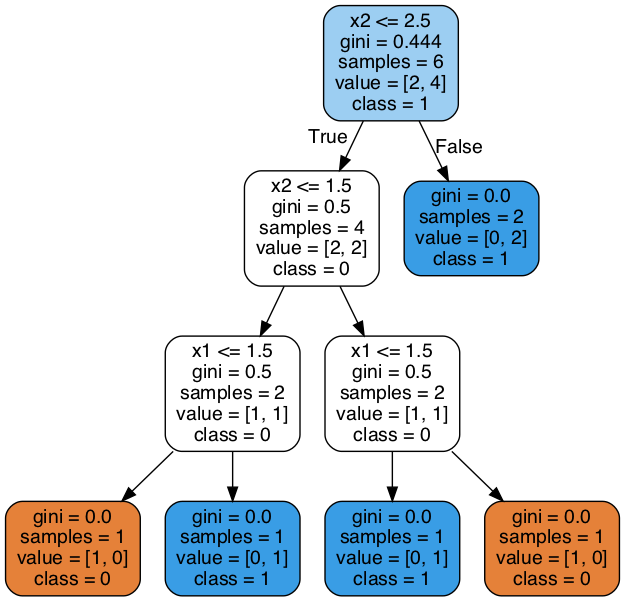

In [10]:
#I won't live code this -- just shows how to produce a PNG visialisation of the decision tree 
#that is produced by the DecisionTreeClassifier.

#If you are doing this at home, then you will need have the graphviz software installed. It should be available on colab. 
#I did it via conda with $conda install graphviz
from sklearn.tree import export_graphviz

# First export as dot file
export_graphviz(tree, 'tree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)

# Then use a system command to convert to a PNG
!dot -Tpng tree.dot -o tree.png -Gdpi=100

# Display the image
from IPython.display import Image
Image('tree.png')

Then we use a system command to create a PNG image to display

A decision tree is an intuitive model: it makes decisions much as we might when faced with a problem by constructing a flowchart of questions. For each of the nodes (except the leaf nodes), the five rows represent:

 * The node question

 * gini: the Gini Impurity of the node. The average (weighted by samples) gini impurity decreases with each level of the tree.
 * samples: number of training observations in the node
 * value: [number of samples in the first class, number of samples in the second class]
 * class: the predicted class at this level
 

#### Run again with limited depth

In practice, we usually want to limit the maximum depth of the decision tree (even in a random forest) so the tree can generalize better to testing data. Although this will lead to reduced accuracy on the training data, it can improve performance on the testing data.

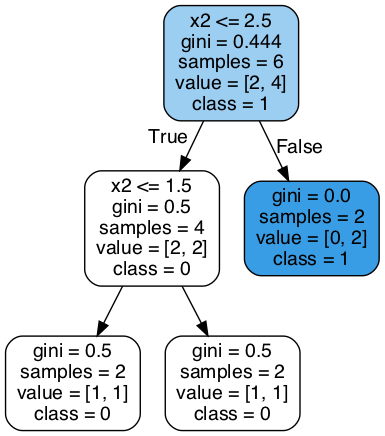

In [13]:
# Export as dot -- again, not live coding this.
export_graphviz(short_tree, 'shorttree.dot', rounded = True, 
                feature_names = ['x1', 'x2'], 
                class_names = ['0', '1'], filled = True)

# Convert to PNG and display
!dot -Tpng shorttree.dot -o shorttree.png -Gdpi=100
Image('shorttree.png')

Our model no longer gets perfect accuracy on the training data. However, it probably would do better on the testing data since we have limited the maximum depth to prevent overfitting.

Limiting the depth of a single decision tree is one way we can try to make a less biased model. Another option is to use an entire forest of trees, training each one on a random subsample of the training data. The final model then takes an average of all the individual decision trees to arrive at a classification. This is the idea behind the random forest.
<img src="Images/Random_forest_diagram_complete.png">



## 1.2 A real example - predicting health

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. To do this, we can use the ~300 pieces of information (or features) collected from the telephone surveys. We'll limit the data to 50,000 individuals to speed up training.

The problem is imbalanced (far more of one label than another) so for assessing performance, we'll look at what is known as a "confusion matrix".


#### Load the data and clean

First step is to load the data into a Pandas *dataframe* and take a look at what we have. 


As we know from the labs, a large proportion of of time needs to be spent cleaning data in preparation for running analyses. To save time, I won't go through the below coding steps in class. 

In [27]:
# Select only columns that contain numbers
df = df.select_dtypes('number')
print('############################################################################')
print("Dimensions of data [rows, columns]:", df.shape)
#df.head()

#The column '_RFHLTH' gives the ground-truth for health. In the data RFHLT is 1,2, or 9. If labelled 9, means 
#Unsure on health/refused to answer, so get rid of that. 1 = good health, 2 =fair or poor health; future code 
#takes either 0 or 1, so convert 2s into 1s and get rid of 9s
#details of data columns are at https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf, 
#which contains hundreds of pages... and the full catalogue can be found at
#https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system?select=2015.csv

# Get rid of 9s
print('############################################################################')
print('Shape of dataframe before cut out rows with Unsure/refused to answer health question:',df.shape)
df = df.loc[df['_RFHLTH'] < 9].copy()
print('after cut:',df.shape)

#replace 2s with 0s
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
#transorms data frame to only contain entries with either good (1) or poor/fair (0) health.

# Rename the column as 'label' because the code we will be using requires  a column called 'label' so that
#it knows how to train the algorithm.
df = df.rename(columns = {'_RFHLTH': 'label'})


# Remove columns with missing values
print('############################################################################')
print('Before dropping columns',df.shape)
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])
#df = df.drop(columns = badcols)
print('After dropping columns',df.shape)

# How many of each value 0, 1
print('############################################################################')
print('The number of rows for the different health values (1=good health, 0=bad/poor health)')
print(df['label'].value_counts())

#fill in missing values
df = df.fillna(df.mean())


############################################################################
Dimensions of data [rows, columns]: (50000, 324)
############################################################################
Shape of dataframe before cut out rows with Unsure/refused to answer health question: (50000, 324)
after cut: (49859, 324)
############################################################################
Before dropping columns (49859, 324)
After dropping columns (49859, 315)
############################################################################
The number of rows for the different health values (1=good health, 0=bad/poor health)
1.0    40453
0.0     9406
Name: label, dtype: int64


There are far more rows with label '1' than '0': this is an imbalanced dataset. In such a dataset we don't want to use accuracy as a performance metric.

#### Split into train and test set

In supervised learning we want to set aside some data as an 'independent' dataset to test our predictions. This is usually some randomly-chosen fraction of the input data. Scikit-learn has a convenience function to make this split easy:

#### Decision Tree on Real Data

First, we'll train the decision tree on the data. Let's leave the depth unlimited and see if we get overfitting!

#### Assess Decision Tree Performance: The Confusion Matrix

Given the number of nodes in our decision tree and the maximum depth, we expect it has overfit to the training data. This means it will do much better on the training data than on the testing data.

We can therefore test the decision tree using the subset of data saved for testing. There are a number of different ways to assess the performance of a decision tree, such as [recall and precision](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall), receiver operating characteristic area under the curve ([ROC AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)), and also plot the ROC curve. [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy) is another metric that can be used to assess performance, but it is not a useful metric when dealing with an imbalanced problem (which is the case here). If you are interested in finding out more, you can look at the original notebook linked above, or at the descriptions linked for each specific metric. 

Below, we will look at a popular method to inspect the performance of a classification model: the confusion matrix.


In [32]:
#the below code plots up the confusion matrix in a nice way.
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
#    plt.grid(None)
#    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

This shows the classifications predicted by the model on the test data along with the real labels. We can see that our model has many false negatives (predicted good health but actually poor health) and false positives (predicted poor health but actually good health). While false-positives are not so bad in this case, the false negatives are not great... Sick people may miss out on treatment because of this mis-classification!


#### Feature Importances
Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used.

### Visualize Full Tree

As before, we can look at the decision tree on the data. This time, we have to limit the maximum depth otherwise the tree will be too large and cannot be converted and displayed as an image.

In [38]:
# Save tree as dot file
features = list(train.columns)

export_graphviz(tree, 'tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
!dot -Tpng tree_real_data.dot -o tree_real_data.png -Gdpi=200

# Visualize
Image(filename='tree_real_data.png')

We can see that our model is extremely deep and has many nodes. To reduce the variance of our model, we could limit the maximum depth or the number of leaf nodes. Another method to reduce the variance is to use more trees, each one trained on a random sampling of the observations. This is where the random forest comes into play.

## 2. Random Forest

This takes the idea of a single decision tree, and creates an ensemble model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.


We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.

On average for the 100 'trees' with a random training set, there are 6800 or so nodes and the depth is around 40. So, there are still a very large number of nodes and the trees are very deep. Each individual tree likely overfits the data particular to that training set, but because the random forest algorithm takes the average of the predictions for each tree, it avoids overfitting.

#### Results
We can now run the classifier on the the subset of the data saved for testing to see how it performs.

Compared to the single decision tree, the model has fewer false postives although slightly more false negatives. Overall, the random forest does significantly better than a single decision tree, and this is what was expected, However, I'm not sure this classifier is ready to be rolled out. Probably too many false negatives, which would mean that people with poor health would be incorrectly classified as having good health, and could miss out on rteatment.